<a href="https://colab.research.google.com/github/Brycexxx/fastai/blob/master/lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_labels = path / 'labels'
path_images = path / 'images'

### Data

In [6]:
fnames = get_image_files(path_images)
fnames[-5:]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00240.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04650.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08041.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009420.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04560.png')]

In [7]:
lb_names = get_image_files(path_labels)
lb_names[:5]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_08055_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_00510_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f00990_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08063_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04530_P.png')]

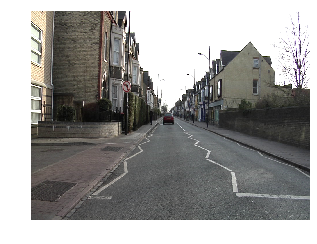

In [8]:
img_f = fnames[100]
img = open_image(img_f)
img.show(figsize=(5, 6))

In [0]:
get_y_fn = lambda x: path_labels / f'{x.stem}_P{x.suffix}'

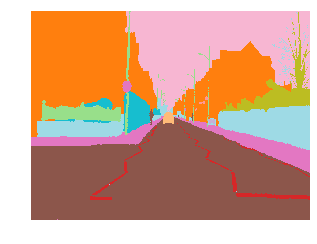

In [10]:
img_label = get_y_fn(img_f)
mask = open_mask(img_label)
mask.show(figsize=(5, 6), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path / 'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### Dataset

In [0]:
size = src_size // 2
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path_images)
                           .split_by_fname_file(path / 'valid.txt')
                           .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats))

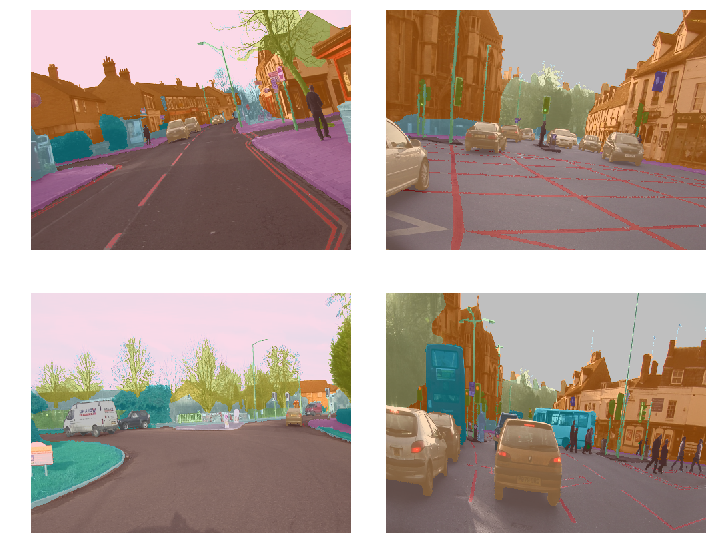

In [16]:
data.show_batch(2, figsize=(10, 8))

In [17]:
data.train_ds.y[0].data

tensor([[[26, 26, 26,  ..., 21, 21, 21],
         [26, 26, 26,  ..., 21, 21, 21],
         [26, 26, 26,  ..., 21, 21, 21],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])

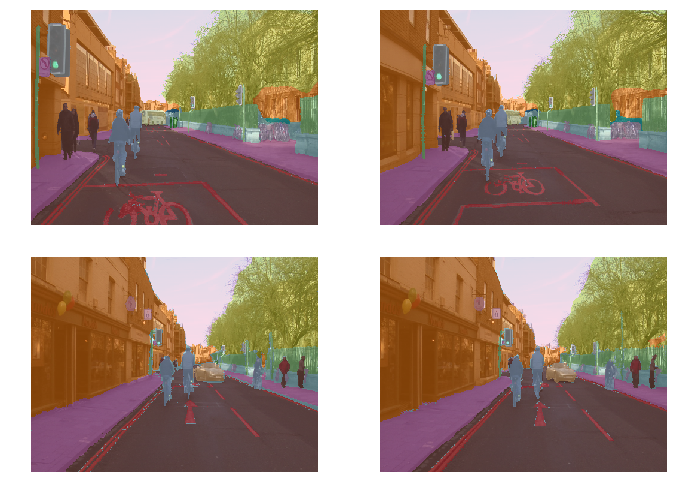

In [18]:
data.show_batch(rows=2, figsize=(10, 7), ds_type=DatasetType.Valid)

### Model

In [13]:
name2id = {v: k for k, v in enumerate(codes)}
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [0]:
void_code = name2id['Void']

def acc_camvid(inp, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (inp.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
weight_decay = 1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=weight_decay)

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


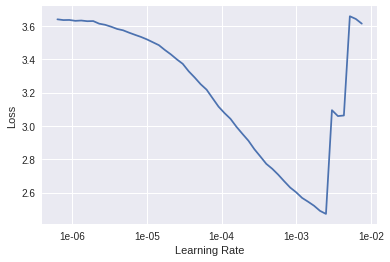

In [29]:
learn.recorder.plot()

In [0]:
lr = 3e-4

* pct_start: Percentage of total number of epochs
所有迭代次数中，lr 上升的比例
> 参考：https://forums.fast.ai/t/what-is-the-pct-start-mean/26168

In [31]:
learn.fit_one_cycle(12, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.764663,1.264802,0.710348
2,1.165419,0.833070,0.805016
3,0.848487,0.698785,0.813667
4,0.710998,0.545987,0.851382
5,0.638525,0.590919,0.830247
6,0.579894,0.468857,0.867338
7,0.540124,0.437630,0.873664
8,0.507250,0.418304,0.877799
9,0.486898,0.409951,0.891955
10,0.452352,0.349818,0.900833


In [0]:
learn.save('stage-1')

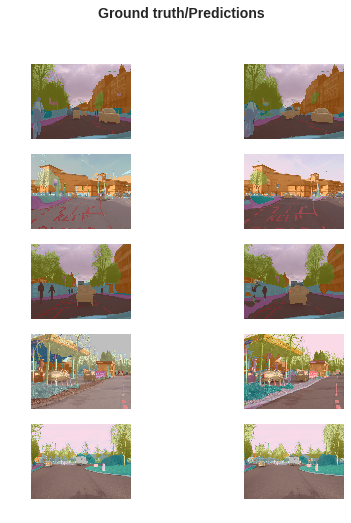

In [33]:
learn.show_results(3, figsize=(7, 8))

In [38]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /root/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /root/.fastai/data/camvid/images;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /root/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), str

In [0]:
learn.unfreeze()

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


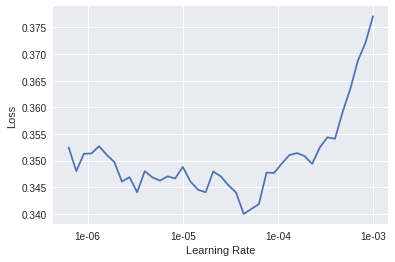

In [41]:
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(14, slice(5e-6, 1e-4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.334330,0.308602,0.907821
2,0.330922,0.305763,0.908379
3,0.317964,0.300205,0.911174
4,0.318960,0.305683,0.911606
5,0.313286,0.324627,0.904089
6,0.311825,0.316699,0.909028
7,0.305978,0.313928,0.904539
8,0.303136,0.319149,0.903494
9,0.294072,0.314248,0.908460
10,0.285944,0.297400,0.915708


In [0]:
learn.save('stage-2')

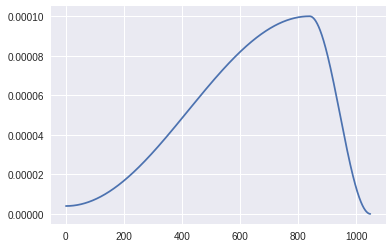

In [44]:
learn.recorder.plot_lr()

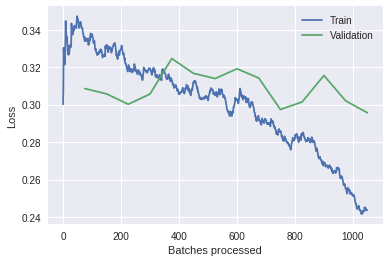

In [45]:
learn.recorder.plot_losses()

### Go big

In [0]:
size = src_size
bs = 2

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats))

In [26]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=weight_decay)
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /root/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /root/.fastai/data/camvid/images;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /root/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), str

In [27]:
learn.data.train_ds[0][0].shape

torch.Size([3, 720, 960])

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


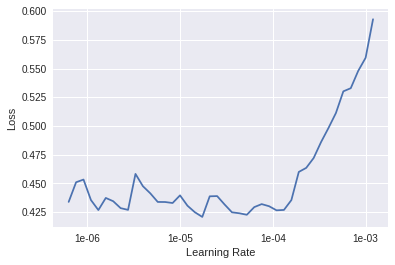

In [29]:
learn.recorder.plot()

In [0]:
lr = 1e-4

In [31]:
learn.fit_one_cycle(12, max_lr=slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.378516,0.334539,0.907411
2,0.339639,0.327867,0.909096
3,0.339977,0.302975,0.912338
4,0.343020,0.342609,0.901571
5,0.338136,0.312095,0.912918
6,0.319539,0.344484,0.900474
7,0.324263,0.393719,0.896702
8,0.300870,0.320061,0.911137
9,0.324081,0.296186,0.917100
10,0.291243,0.270796,0.924854


In [0]:
learn.save('stage-1-big')

In [33]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


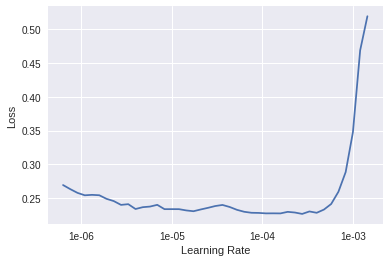

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(12, max_lr=slice(5e-6, 7e-4))

epoch,train_loss,valid_loss,acc_camvid
1,0.267931,0.309659,0.913018
2,0.443125,0.570186,0.878564
3,0.540325,0.329102,0.915833
4,0.457420,0.334119,0.921979
5,0.418328,0.316055,0.914283
6,0.371315,0.279607,0.927655
7,0.307619,0.260888,0.932037
8,0.264963,0.235887,0.938713
9,0.224452,0.241067,0.934203
10,0.219344,0.246014,0.932603


In [0]:
learn.save("stage-2-big")

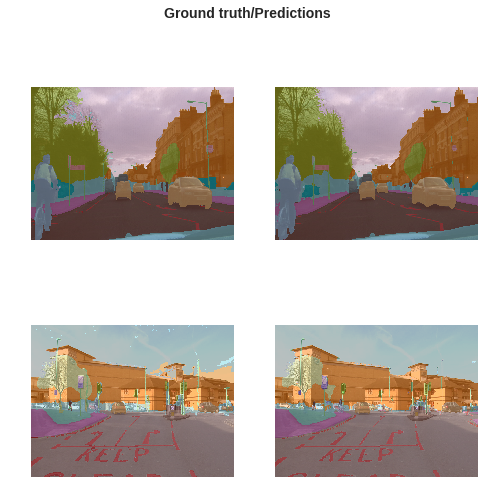

In [38]:
learn.show_results(3, figsize=(8, 8))

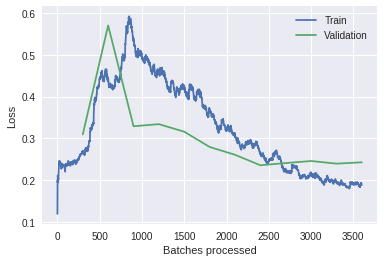

In [39]:
learn.recorder.plot_losses()

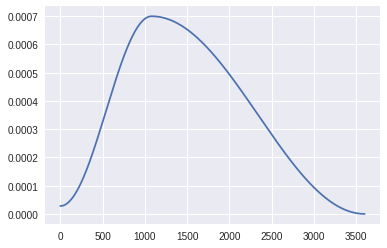

In [40]:
learn.recorder.plot_lr()